# Results Analysis

In [1]:
from optimization.acs import ACS_VRP,ACS_TSP
from optimization.bso import BSO_VRP,BSO_TSP
from optimization.hybrid_acs_bso import ACSBSO_VRP,ACSBSO_TSP
from optimization.ga import GA_VRP
from optimization.sa import SA_VRP
from optimization.tabu_search import TS_VRP
from optimization.dka import DKA_VRP

from optimization.aco import ACO_VRP,ACO_TSP
from optimization.haco import HACO_VRP,HACO_TSP

from optimization.koneksi import ConDB

import sql_connection
import json
import time
import random
import datetime
import copy

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [2]:
def generate_data(n = 30, random_state = None):
    random.seed(random_state)
    query = """SELECT 
                    p.post_id,
                    p.post_type,
                    CASE
                        WHEN pj.pj_jam_buka = pj.pj_jam_tutup THEN "tutup"
                        ELSE "buka"
                    END AS is_operate
                FROM 
                    posts p
                LEFT JOIN
                    posts_jadwal pj
                    ON p.post_id = pj.pj_id_tempat AND pj.pj_hari = "minggu"
                """

    df_location = sql_connection.read_from_sql(query)
    
    tourid = df_location[(df_location['post_type']=="location")&
                         (df_location['is_operate'] != "tutup")]['post_id'].values.tolist()
    tourid = random.sample(tourid,n)
    idhotel = df_location[df_location['post_type']=="hotel"]['post_id'].values.tolist()
    idhotel = idhotel[random.randint(0,len(idhotel)-1)]
    
    db = ConDB()

    hotel = db.HotelbyID(idhotel)
    tur = db.WisatabyID(tourid)
    timematrix = db.TimeMatrixbyID(hotel._id,tourid)
    
    return hotel,tur,timematrix

## Analisis
scenario analisis:
1. semua degree 1, 30 pois, 3 hari wisata, all method cek fitness, travel duration, total tarif, rata-rata rating, poi included, running time
2. semua degree 1, 0, 5-10-15-20-25-30 pois, 3 hari wisata, all method, cek running time
3. degree travel duration 1 sisanya 0, 5-10-15-20-25-30 pois, 365 hari wisata, all method, cek travel duration and travel days
4. degree tarif 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek total tarif
5. degree rating 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek rata rata rating

story:
1. overview: jelasin dulu secara keseluruhan dengan scenario analisis no. 1 terus breakdown best model dengan beberapa random berbeda dan running time nya

In [3]:
def find_node(node_id,tour):
    for node in tour:
        if node._id == node_id:
            return node
    return False

def time_to_second(time):
    return (time.hour*3600)+(time.minute*60)+time.second

def diff_second_between_time(time_a,time_b):
    #input: time_a and time_b, datetime.time()
    #output: time_b - time_a, seconds (int)
    return time_to_second(time_b) - time_to_second(time_a)

def get_attribute_analysis(solution):
    days_needed = len(solution)
    poi_included = len(sum([sol["index"] for sol in solution],[]))
    avg_rating = sum(sum([sol["rating"] for sol in solution],[]))/poi_included
    total_tarif = sum(sum([sol["tarif"] for sol in solution],[]))
    total_duration = sum([diff_second_between_time(j[0],j[-1]) for j in [i['waktu'] for i in solution]])
    return days_needed,poi_included,avg_rating,total_tarif,total_duration

def get_analysis(model,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating):
    start = time.time()
    model.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness = model.construct_solution()[-2:]
    end = time.time()
    run_time = end-start
    
    daily_fitness = []
    for day in solution:
        daily_fitness.append(model.MAUT([day],use_penalty=False))
    days_needed,poi_included,avg_rating,total_tarif,total_duration = get_attribute_analysis(solution)
    results = {"solution":[sol["index"] for sol in solution],
               "fitness":fitness,
               "daily_fitness":daily_fitness,
               "days_needed":days_needed,
               "poi_included":poi_included,
               "avg_rating":avg_rating,
               "total_tarif":total_tarif,
               "total_duration":total_duration,
               "run_time":run_time}
    
    return results

In [4]:
def get_detail_node_on_solution(solution):
    db = ConDB()
    node_solution = []
    for i in solution:
        nodes = db.WisatabyID(i)
        node_solution.append(nodes)
    return node_solution

def visualize_solution(solution_node,hotel):
    # Sample VRP data
    vrp_data = [[hotel]+sol+[hotel] for sol in solution_node]
    
    # Generate random node coordinates
    node_coords = {node._id: (float(node.long), float(node.lat)) for node in set(node for route in vrp_data for node in route)}  

    # Number of routes (you can calculate this)
    num_routes = len(vrp_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,9))

    # Define the colors for routes using a colormap
    cmap = plt.get_cmap('tab20', num_routes)

    for i, route in enumerate(vrp_data):
        x = [node_coords[node._id][0] for node in route]
        y = [node_coords[node._id][1] for node in route]
        color = cmap(i)  # Get the color for the route
        # Plot the nodes (scatter plot)
        ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)

        for j in range(len(x) - 1):
            # Make the arrow heads larger by increasing mutation_scale
            arrow = FancyArrowPatch(
                (x[j], y[j]), (x[j + 1], y[j + 1]),
                arrowstyle='->', mutation_scale=15, color=color
            )
            ax.add_patch(arrow)

    # Set node 159 (start and end point) to black
    start_x, start_y = node_coords[hotel._id]
    ax.scatter(start_x, start_y, c='k', label='Hotel', s=100)

    # Add labels for nodes
    for node, (x, y) in node_coords.items():
        ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add legend
    ax.legend()

    plt.show()



### 1. Overview

In [5]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

In [6]:
tur

[MALIOBORO JOGJAKARTA(00:00:00-00:00:00),
 Bringin Kembar Yogyakarta(00:00:00-00:00:00),
 Titik Nol Km Yogyakarta(00:00:00-00:00:00),
 Tarunasura Wijilan Gate(00:00:00-00:00:00),
 Yogyakarta Northern Square(00:00:00-00:00:00),
 Pasar Ngasem(00:00:00-00:00:00),
 Situs Gua Seluman(00:00:00-00:00:00),
 Pakualaman Palace(00:00:00-00:00:00),
 Bentara Budaya Yogyakarta (BBY)(00:00:00-00:00:00),
 The Lost World Castle(00:00:00-00:00:00),
 Grojogan Watu Purbo Gate(00:00:00-00:00:00),
 House of Chocolate Monggo & Gelato Tirtodipuran(00:00:00-00:00:00),
 Sermo Reservoir Dam(00:00:00-00:00:00),
 Jogja T-Shirt Jethe(00:00:00-00:00:00),
 ALUN ALUN KIDUL YOGYAKARTA(00:00:00-00:00:00),
 Paintball Jupiter Jogja(00:00:00-00:00:00),
 Desa Wisata Pentingsari(00:00:00-00:00:00),
 GOLDEN BIOSKOP VIRTUAL REALITY(00:00:00-00:00:00),
 Bukit Pangol(00:00:00-00:00:00),
 Bukit Rhema Gereja Ayam(00:00:00-00:00:00),
 The Palace of Yogyakarta(00:00:00-00:00:00),
 Hutan Pinus Pengger(00:00:00-00:00:00),
 Gembira Lok

In [8]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[46, 73, 74, 93, 7, 9, 88],
  [16, 39, 69, 76, 10, 35, 40, 1],
  [54, 18, 95, 34, 86, 22, 4]],
 'fitness': 0.6752524041214517,
 'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.5636363636363635,
 'total_tarif': 26500,
 'total_duration': 127320,
 'run_time': 1.9510648250579834}

In [7]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[53, 9, 95, 16, 73, 46],
  [88, 35, 4, 11, 10, 7, 22, 40],
  [74, 39, 64, 34, 51]],
 'fitness': 0.6270463671048466,
 'daily_fitness': [0.6408408555729985, 0.6509428237106809, 0.6048331298331296],
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.631578947368421,
 'total_tarif': 73500,
 'total_duration': 123960,
 'run_time': 16.339945793151855}

In [41]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[69, 18, 4, 88, 71, 73, 22],
  [76, 40, 64, 34, 54, 95, 46],
  [29, 47, 16, 9, 86, 10, 7, 1]],
 'fitness': 0.5938038556094113,
 'daily_fitness': [0.6443993836850979, 0.5988282385603814, 0.538307278039421],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.536363636363636,
 'total_tarif': 168000,
 'total_duration': 124800,
 'run_time': 0.4632883071899414}

In [44]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 4, 86, 18, 95, 73, 16, 71],
  [22, 53, 7, 88, 1, 10, 9],
  [29, 51, 34, 64, 40]],
 'fitness': 0.6167016331698871,
 'daily_fitness': [0.6300335411942555, 0.6557955767777197, 0.5602529580208152],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.58,
 'total_tarif': 100500,
 'total_duration': 123420,
 'run_time': 23.437602996826172}

In [7]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[69, 18, 46, 1, 22, 16, 95, 73, 9],
  [34, 76, 7, 4, 35, 74, 40, 10],
  [11, 54, 71, 93, 86, 88]],
 'fitness': 0.6924740386265574,
 'daily_fitness': [0.6668440025582881, 0.648628008895866, 0.6088735173556601],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120000,
 'run_time': 24.942962169647217}

In [31]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[73, 95, 72, 18, 11, 10, 86, 35, 9, 53],
  [46, 1, 7, 69, 4, 88, 51],
  [74, 39, 64, 34, 40]],
 'fitness': 0.616598958067212,
 'daily_fitness': [0.5790053200767488, 0.6608950738415026, 0.6167128176056748],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.631818181818181,
 'total_tarif': 156500,
 'total_duration': 120180,
 'run_time': 30.51319456100464}

In [7]:
print("GA - VRP")
ga_vrp = GA_VRP(random_state=100)
results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ga_vrp

GA - VRP


{'solution': [[73, 76, 93, 9, 86, 18, 10, 4],
  [39, 34, 71, 88, 46],
  [16, 35, 7, 54, 22, 95, 1]],
 'fitness': 0.6560393530631624,
 'daily_fitness': [0.6554685228792372, 0.6409133525204952, 0.6102796674225246],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.56,
 'total_tarif': 23500,
 'total_duration': 125460,
 'run_time': 0.7301931381225586}

In [8]:
print("TS - VRP")
ts_vrp = TS_VRP(random_state=100)
results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ts_vrp

TS - VRP


{'solution': [[34, 35, 46, 10, 18, 7, 40, 9, 73],
  [76, 16, 51, 22, 1, 88, 74],
  [93, 11, 95, 86, 54, 4]],
 'fitness': 0.678106072352104,
 'daily_fitness': [0.6629353450782021, 0.6425947729519157, 0.5998417422524563],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.554545454545454,
 'total_tarif': 20000,
 'total_duration': 126180,
 'run_time': 0.6893174648284912}

In [9]:
print("SA - VRP")
sa_vrp = SA_VRP(random_state=100)
results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_sa_vrp

SA - VRP


{'solution': [[7, 76, 40, 1, 35, 4, 73, 88, 9, 46],
  [69, 11, 18, 71, 16, 22, 74],
  [34, 54, 39, 86, 95, 10]],
 'fitness': 0.6852944383914017,
 'daily_fitness': [0.6811867695796266, 0.6283483051340194, 0.5921201814058958],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 29000,
 'total_duration': 125880,
 'run_time': 0.9566409587860107}

In [7]:
print("DKA - VRP")
dka_vrp = DKA_VRP(random_state=100)
results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_dka_vrp

DKA - VRP


{'solution': [[40, 74, 22, 86, 18, 73, 35, 88, 1],
  [76, 39, 46, 53, 10, 9, 95, 4],
  [11, 69, 16, 71, 93, 7]],
 'fitness': 0.6809551617005032,
 'daily_fitness': [0.6595343479272049, 0.6426476466655039, 0.6330002834467121],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.617391304347825,
 'total_tarif': 56500,
 'total_duration': 122040,
 'run_time': 1.7003161907196045}

In [7]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[22, 71, 35, 46, 53, 7],
  [69, 18, 86, 1, 11, 74, 9, 4, 88],
  [64, 39, 93, 73, 10, 40]],
 'fitness': 0.6441596249135929,
 'daily_fitness': [0.63160249142392, 0.6650455695098552, 0.6139192322228036],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.652380952380951,
 'total_tarif': 81500,
 'total_duration': 127740,
 'run_time': 5.568957805633545}

In [12]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[53, 46, 1, 7, 88],
  [74, 9, 64, 39, 10, 4, 35],
  [47, 72, 18, 22, 76, 51, 40]],
 'fitness': 0.5247974369684897,
 'daily_fitness': [0.6667756846328275, 0.6233918033025176, 0.4667756846328275],
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.647368421052632,
 'total_tarif': 248500,
 'total_duration': 129300,
 'run_time': 7.412907600402832}

In [9]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[11, 10, 7, 4, 35, 93, 40, 22],
  [86, 71, 88, 73, 16, 46, 1, 9],
  [69, 39, 64, 76, 18, 95, 74]],
 'fitness': 0.6726471184286918,
 'daily_fitness': [0.6399583551369266, 0.6661186696900983, 0.6087247078318506],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.604347826086956,
 'total_tarif': 56500,
 'total_duration': 129480,
 'run_time': 14.806365489959717}

In [13]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[53, 46, 1, 7, 88],
  [9, 64, 34, 51, 29, 40],
  [86, 74, 73, 16, 54, 95, 22, 4]],
 'fitness': 0.6091926010420162,
 'daily_fitness': [0.6667756846328275, 0.5703758212686785, 0.6248130341880342],
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.573684210526316,
 'total_tarif': 87500,
 'total_duration': 126780,
 'run_time': 11.865092515945435}

### 2. Overview: Variasi hasil berdasarkan node yang berbeda

In [18]:
random_ls = [10,30,60,80,100]
random_node_analysis ={
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_tsp"].append(results_acs_tsp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_tsp"].append(results_bso_tsp)
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_tsp"].append(results_acsbso_tsp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [19]:
random_node_analysis

{'acs_vrp': [{'solution': [[6, 18, 44, 71, 49, 10, 21, 2],
    [89, 12, 46, 22, 36, 32, 57, 66],
    [39, 34, 51, 74]],
   'fitness': 0.6458440766233293,
   'daily_fitness': [0.6079666502785972,
    0.6401692068174369,
    0.6025206899377252],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 120180,
   'run_time': 4.288721084594727},
  {'solution': [[46, 73, 74, 93, 7, 9, 88],
    [16, 39, 69, 76, 10, 35, 40, 1],
    [54, 18, 95, 34, 86, 22, 4]],
   'fitness': 0.6752524041214517,
   'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.5636363636363635,
   'total_tarif': 26500,
   'total_duration': 127320,
   'run_time': 1.9145057201385498},
  {'solution': [[12, 55, 88, 2, 26, 52, 7, 36],
    [39, 95, 66, 32, 15, 23, 10, 21],
    [6, 14, 79, 45, 17, 33]],
   'fitness': 0.6738332131340155,
   'daily_fitness': [0.6736454372623574,
    0.623

In [14]:
random_ls = [10,30,60,80,100]
random_node_analysis ={
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_tsp"].append(results_acs_tsp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_tsp"].append(results_bso_tsp)
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_tsp"].append(results_acsbso_tsp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [15]:
random_node_analysis

{'acs_vrp': [{'solution': [[6, 18, 44, 71, 49, 10, 21, 2],
    [89, 12, 46, 22, 36, 32, 57, 66],
    [39, 34, 51, 74]],
   'fitness': 0.6458440766233293,
   'daily_fitness': [0.6079666502785972,
    0.6401692068174369,
    0.6025206899377252],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 120180,
   'run_time': 4.41132116317749},
  {'solution': [[46, 73, 74, 93, 7, 9, 88],
    [16, 39, 69, 76, 10, 35, 40, 1],
    [54, 18, 95, 34, 86, 22, 4]],
   'fitness': 0.6752524041214517,
   'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.5636363636363635,
   'total_tarif': 26500,
   'total_duration': 127320,
   'run_time': 1.9179232120513916},
  {'solution': [[12, 55, 88, 2, 26, 52, 7, 36],
    [39, 95, 66, 32, 15, 23, 10, 21],
    [6, 14, 79, 45, 17, 33]],
   'fitness': 0.6738332131340155,
   'daily_fitness': [0.6736454372623574,
    0.6234

In [11]:
random_ls = [10,30,60,80,100]
random_node_analysis ={
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)


random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [8]:
random_ls = [10,30,60,80,100]
random_node_analysis ={
    "dka_vrp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [9]:
random_node_analysis

{'dka_vrp': [{'solution': [[46, 38, 66, 18, 71, 21, 36],
    [74, 99, 44, 12, 10, 48, 49],
    [39, 32, 6, 89, 57, 2]],
   'fitness': 0.6201292836592737,
   'daily_fitness': [0.6092462365969002,
    0.5758027227606871,
    0.6210863241560143],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.569999999999999,
   'total_tarif': 65000,
   'total_duration': 120360,
   'run_time': 1.4832768440246582},
  {'solution': [[40, 74, 22, 86, 18, 73, 35, 88, 1],
    [76, 39, 46, 53, 10, 9, 95, 4],
    [11, 69, 16, 71, 93, 7]],
   'fitness': 0.6809551617005032,
   'daily_fitness': [0.6595343479272049,
    0.6426476466655039,
    0.6330002834467121],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.617391304347825,
   'total_tarif': 56500,
   'total_duration': 122040,
   'run_time': 2.1187994480133057},
  {'solution': [[66, 52, 26, 99, 21, 36, 10, 15, 88],
    [55, 17, 39, 2, 32, 23, 33],
    [14, 79, 45, 84, 95, 7]],
   'fitness': 0.6506952623687942,
   'daily_fitness': [0

#### random_node_analysis

In [19]:
random_ls = [10,30,60,80,100]
random_node_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])

    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_tsp"].append(results_aco_tsp)
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["haco_vrp"].append(results_haco_vrp)
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["haco_tsp"].append(results_haco_tsp)

random state =  10
random state =  30
random state =  60
random state =  80
random state =  100


In [20]:
random_node_analysis

{'aco_vrp': [{'solution': [[6, 12, 18, 34, 51, 66],
    [46, 2, 32, 36, 22, 10, 44, 74, 21],
    [39, 71, 49, 57, 89]],
   'fitness': 0.6424232947303251,
   'daily_fitness': [0.5929142084562439,
    0.6552083333333332,
    0.5788997459849231],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 124080,
   'run_time': 3.2200188636779785},
  {'solution': [[46, 95, 18, 93, 73, 88, 10, 9],
    [1, 7, 11, 76, 53, 22, 71],
    [74, 86, 4, 35, 51, 40]],
   'fitness': 0.6640636406509423,
   'daily_fitness': [0.6722064146171289,
    0.6343659151694867,
    0.6217643467643468],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.623809523809523,
   'total_tarif': 50000,
   'total_duration': 121080,
   'run_time': 2.775426149368286},
  {'solution': [[55, 26, 23, 7, 33, 32, 52, 36, 15],
    [12, 79, 14, 10, 21, 17, 2, 66],
    [6, 39, 88, 95, 42]],
   'fitness': 0.6575282201681654,
   'daily_fitness': [0.644653481903957,
    0

### 3. Overview: Visualization

In [16]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

In [12]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[69, 18, 46, 1, 22, 16, 95, 73, 9],
  [34, 76, 7, 4, 35, 74, 40, 10],
  [11, 54, 71, 93, 86, 88]],
 'fitness': 0.6924740386265574,
 'daily_fitness': [0.6668440025582881, 0.648628008895866, 0.6088735173556601],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120000,
 'run_time': 24.701404094696045}

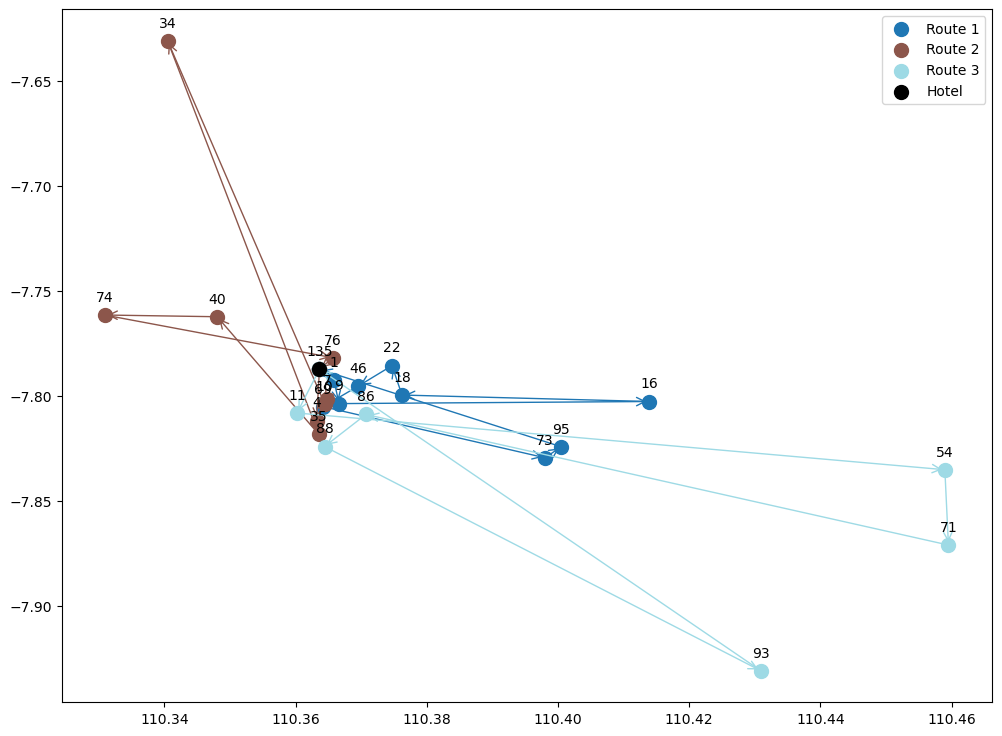

In [13]:
sol_node = get_detail_node_on_solution(results_acsbso_vrp['solution'])
visualize_solution(sol_node,hotel)

In [17]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[46, 73, 74, 93, 7, 9, 88],
  [16, 39, 69, 76, 10, 35, 40, 1],
  [54, 18, 95, 34, 86, 22, 4]],
 'fitness': 0.6752524041214517,
 'daily_fitness': [0.68594776585848, 0.6273126344554917, 0.6005634411884411],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.5636363636363635,
 'total_tarif': 26500,
 'total_duration': 127320,
 'run_time': 1.9076247215270996}

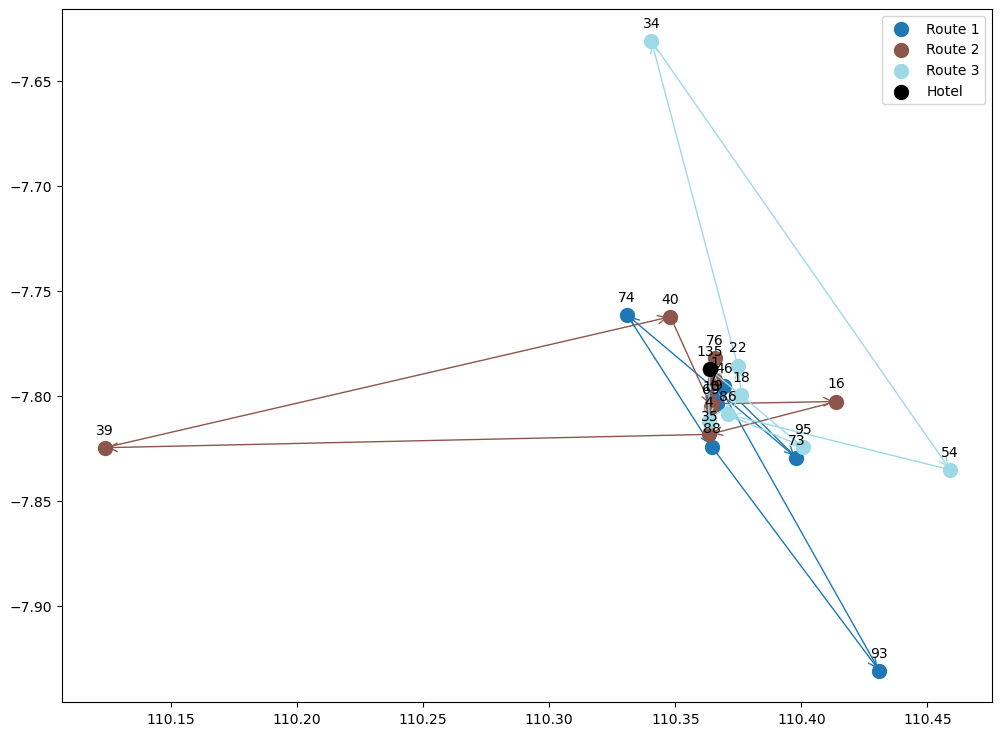

In [18]:
sol_node = get_detail_node_on_solution(results_acs_vrp['solution'])
visualize_solution(sol_node,hotel)

In [19]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[73, 95, 72, 18, 11, 10, 86, 35, 9, 53],
  [46, 1, 7, 69, 4, 88, 51],
  [74, 39, 64, 34, 40]],
 'fitness': 0.616598958067212,
 'daily_fitness': [0.5790053200767488, 0.6608950738415026, 0.6167128176056748],
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.631818181818181,
 'total_tarif': 156500,
 'total_duration': 120180,
 'run_time': 31.34832763671875}

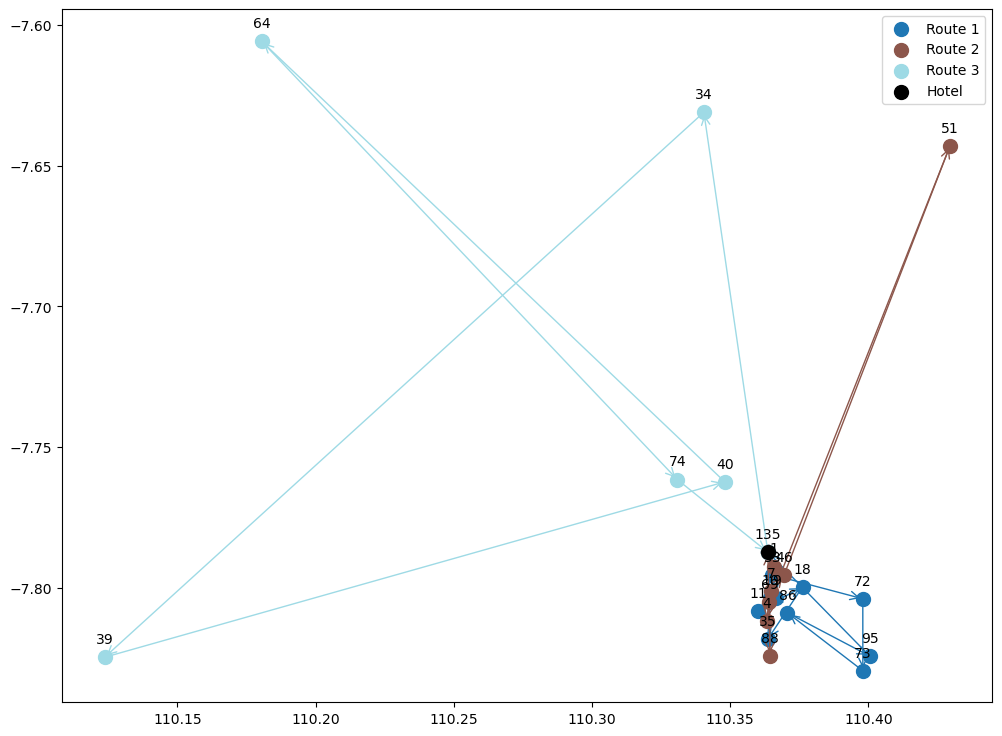

In [20]:
sol_node = get_detail_node_on_solution(results_acsbso_tsp['solution'])
visualize_solution(sol_node,hotel)

In [20]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[13, 7, 89, 96, 4, 43, 35],
  [81, 39, 57, 15, 24, 85, 5, 17],
  [8, 60, 44, 20, 34, 92]],
 'fitness': 0.6501071475981872,
 'daily_fitness': [0.6703068996415773, 0.567839008363202, 0.6343637992831545],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.604761904761905,
 'total_tarif': 86000,
 'total_duration': 117060,
 'run_time': 13.519371509552002}

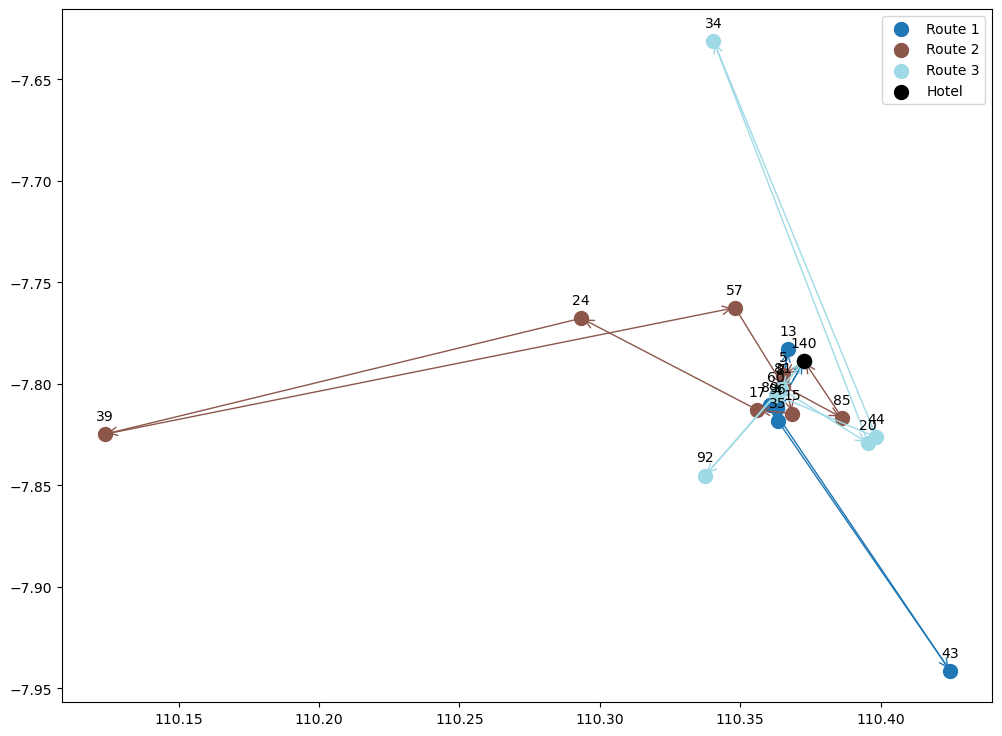

In [21]:
sol_node = get_detail_node_on_solution(results_haco_vrp['solution'])
visualize_solution(sol_node,hotel)

### 4. Fitness in Several DOI Combination

In [13]:
doi_ls = [[1,1,1],[1,1,0],[1,0,1],[0,1,1],[1,0,0],[0,0,1],[0,1,0]]
doi_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}

for i in doi_ls:
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = i[0],i[1],i[2]
    
    print("DOI = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["aco_vrp"].append(results_aco_vrp)

    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["aco_tsp"].append(results_aco_tsp)

    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["haco_vrp"].append(results_haco_vrp)

    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["haco_tsp"].append(results_haco_tsp)

DOI =  [1, 1, 1]
DOI =  [1, 1, 0]
DOI =  [1, 0, 1]
DOI =  [0, 1, 1]
DOI =  [1, 0, 0]
DOI =  [0, 0, 1]
DOI =  [0, 1, 0]


In [14]:
doi_analysis

{'aco_vrp': [{'solution': [[22, 71, 35, 46, 53, 7],
    [69, 18, 86, 1, 11, 74, 9, 4, 88],
    [64, 39, 93, 73, 10, 40]],
   'fitness': 0.6441596249135929,
   'daily_fitness': [0.63160249142392, 0.6650455695098552, 0.6139192322228036],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.652380952380951,
   'total_tarif': 81500,
   'total_duration': 127740,
   'run_time': 5.277456045150757},
  {'solution': [[86, 54, 71, 73, 88, 93, 9],
    [76, 22, 1, 53, 46, 7, 10, 35],
    [11, 4, 18, 95, 16, 39, 74, 40]],
   'fitness': 0.6791055681531872,
   'daily_fitness': [0.6254472159234065,
    0.6124779541446208,
    0.642888636936256],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.578260869565216,
   'total_tarif': 48500,
   'total_duration': 124320,
   'run_time': 7.7615320682525635},
  {'solution': [[74, 73, 88, 10, 35, 93, 71],
    [34, 51, 53, 46, 1, 7],
    [69, 4, 86, 22, 40, 76, 64, 9]],
   'fitness': 0.6232875457875456,
   'daily_fitness': [0.544300298466965

In [49]:
doi_ls = [[1,1,1],[1,1,0],[1,0,1],[0,1,1],[1,0,0],[0,0,1],[0,1,0]]
doi_analysis = {
    "aco_tsp": [],
    "haco_tsp": []
}

for i in doi_ls:
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = i[0],i[1],i[2]
    
    print("DOI = ",i)

    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["aco_tsp"].append(results_aco_tsp)

    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    doi_analysis["haco_tsp"].append(results_haco_tsp)

DOI =  [1, 1, 1]
DOI =  [1, 1, 0]
DOI =  [1, 0, 1]
DOI =  [0, 1, 1]
DOI =  [1, 0, 0]
DOI =  [0, 0, 1]
DOI =  [0, 1, 0]


In [50]:
doi_analysis

{'aco_tsp': [{'solution': [[53, 46, 1, 7, 88],
    [74, 9, 64, 39, 10, 4, 35],
    [47, 72, 18, 22, 76, 51, 40]],
   'fitness': 0.5247974369684897,
   'daily_fitness': [0.6667756846328275,
    0.6233918033025176,
    0.4667756846328275],
   'days_needed': 3,
   'poi_included': 19,
   'avg_rating': 4.647368421052632,
   'total_tarif': 248500,
   'total_duration': 129300,
   'run_time': 7.533846855163574},
  {'solution': [[76, 22, 1, 53, 46, 7, 10, 4],
    [54, 71, 93, 64, 40],
    [88, 86, 9, 18, 72, 95, 73, 16, 74]],
   'fitness': 0.6103577727387252,
   'daily_fitness': [0.6196491559586798,
    0.5798185941043085,
    0.5793178382464097],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.581818181818182,
   'total_tarif': 132500,
   'total_duration': 122640,
   'run_time': 5.429476261138916},
  {'solution': [[53, 46, 1, 7, 88],
    [9, 64, 39, 10, 4, 35],
    [74, 73, 69, 93, 71, 22]],
   'fitness': 0.5901215015920899,
   'daily_fitness': [0.5840455840455843,
    0.5453347

### 5. Running Time

In [5]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    if len(run_time_analysis["acs_vrp"])==0 or run_time_analysis["acs_vrp"][-1] < max_runtime:
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acs_vrp"].append(results_acs_vrp["run_time"])
    
    if len(run_time_analysis["acs_tsp"])==0 or run_time_analysis["acs_tsp"][-1] < max_runtime:
        acs_tsp = ACS_TSP(random_state=100)
        results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acs_tsp"].append(results_acs_tsp["run_time"])
    
    if len(run_time_analysis["bso_vrp"])==0 or run_time_analysis["bso_vrp"][-1] < max_runtime:
        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["bso_vrp"].append(results_bso_vrp["run_time"])
    
    if len(run_time_analysis["bso_tsp"])==0 or run_time_analysis["bso_tsp"][-1] < max_runtime:
        bso_tsp = BSO_TSP(random_state=100)
        results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["bso_tsp"].append(results_bso_tsp["run_time"])
    
    if len(run_time_analysis["acsbso_vrp"])==0 or run_time_analysis["acsbso_vrp"][-1] < max_runtime:
        acsbso_vrp = ACSBSO_VRP(random_state=100)
        results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_vrp"].append(results_acsbso_vrp["run_time"])
    
    if len(run_time_analysis["acsbso_tsp"])==0 or run_time_analysis["acsbso_tsp"][-1] < max_runtime:
        acsbso_tsp = ACSBSO_TSP(random_state=100)
        results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_tsp"].append(results_acsbso_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [6]:
run_time_analysis

{'acs_vrp': [0.12089037895202637,
  0.6768441200256348,
  0.8244712352752686,
  2.964085102081299,
  5.8633153438568115,
  4.715360879898071,
  12.253792524337769,
  22.833189487457275,
  25.061843156814575,
  21.20034909248352,
  31.161901712417603,
  21.297510623931885,
  23.933696031570435,
  29.33656907081604,
  32.093711614608765,
  41.04368472099304,
  36.31186056137085],
 'acs_tsp': [0.749945878982544,
  1.3509736061096191,
  1.6577692031860352,
  6.553305149078369,
  8.82589054107666,
  17.269057273864746,
  20.001986980438232,
  17.93183732032776,
  35.312899351119995,
  35.631351709365845,
  37.189401388168335,
  39.250168323516846,
  40.81306743621826,
  75.05329513549805,
  112.71414470672607,
  73.33214449882507,
  90.77346897125244],
 'bso_vrp': [0.02660655975341797,
  0.0762946605682373,
  0.023143529891967773,
  0.26807475090026855,
  0.488175630569458,
  0.9499270915985107,
  0.8853425979614258,
  1.0472996234893799,
  3.8708512783050537,
  3.062171220779419,
  3.94267

In [15]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    if len(run_time_analysis["aco_vrp"])==0 or run_time_analysis["aco_vrp"][-1] < max_runtime:
        aco_vrp = ACO_VRP(random_state=100)
        results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["aco_vrp"].append(results_aco_vrp["run_time"])
    
    if len(run_time_analysis["aco_tsp"])==0 or run_time_analysis["aco_tsp"][-1] < max_runtime:
        aco_tsp = ACO_TSP(random_state=100)
        results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["aco_tsp"].append(results_aco_tsp["run_time"])
    
    if len(run_time_analysis["haco_vrp"])==0 or run_time_analysis["haco_vrp"][-1] < max_runtime:
        haco_vrp = HACO_VRP(random_state=100)
        results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["haco_vrp"].append(results_haco_vrp["run_time"])
    
    if len(run_time_analysis["haco_tsp"])==0 or run_time_analysis["haco_tsp"][-1] < max_runtime:
        haco_tsp = HACO_TSP(random_state=100)
        results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["haco_tsp"].append(results_haco_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [16]:
run_time_analysis

{'aco_vrp': [0.5072586536407471,
  1.5174236297607422,
  2.4383482933044434,
  4.1169538497924805,
  5.801013231277466,
  5.0580668449401855,
  6.237070083618164,
  7.1364827156066895,
  10.249159097671509,
  11.965409994125366,
  11.438562631607056,
  11.97450590133667,
  14.03102731704712,
  22.154757499694824,
  24.32870388031006,
  18.88797950744629,
  23.830101013183594],
 'aco_tsp': [0.8298609256744385,
  1.5060944557189941,
  2.369814157485962,
  3.430854320526123,
  4.8031837940216064,
  6.437254905700684,
  8.117571830749512,
  10.950874328613281,
  13.52927041053772,
  16.4480938911438,
  18.730835437774658,
  23.794976949691772,
  25.661245584487915,
  29.973273992538452,
  34.7427294254303,
  39.65538215637207,
  43.7692391872406],
 'haco_vrp': [1.8642351627349854,
  4.294220447540283,
  4.964016675949097,
  5.481198310852051,
  8.25956678390503,
  14.661466360092163,
  16.31305980682373,
  14.197788000106812,
  13.76815676689148,
  22.574778079986572,
  29.205066919326782,

In [45]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "aco_tsp": [],
    "haco_tsp": []
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    if len(run_time_analysis["aco_tsp"])==0 or run_time_analysis["aco_tsp"][-1] < max_runtime:
        aco_tsp = ACO_TSP(random_state=100)
        results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["aco_tsp"].append(results_aco_tsp["run_time"])
    if len(run_time_analysis["haco_tsp"])==0 or run_time_analysis["haco_tsp"][-1] < max_runtime:
        haco_tsp = HACO_TSP(random_state=100)
        results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["haco_tsp"].append(results_haco_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [46]:
run_time_analysis

{'aco_tsp': [0.2635335922241211,
  1.282886028289795,
  2.3953678607940674,
  4.195538282394409,
  5.087548732757568,
  7.437167644500732,
  11.88499665260315,
  9.708583354949951,
  16.319014072418213,
  18.843014001846313,
  19.417676210403442,
  26.56031608581543,
  24.809733867645264,
  28.056148767471313,
  47.576990365982056,
  40.191930532455444,
  50.40630078315735],
 'haco_tsp': [0.8260340690612793,
  1.7418432235717773,
  5.082241773605347,
  6.446778774261475,
  7.079749584197998,
  12.112157344818115,
  14.315203666687012,
  18.84384274482727,
  26.477680206298828,
  20.95894432067871,
  31.49805998802185,
  30.912598848342896,
  44.706035137176514,
  48.26541233062744,
  51.72647500038147,
  77.06598258018494,
  72.70267701148987]}

### 6. Fitness in Several Number of Nodes

In [9]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
fitness_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}

for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["acs_vrp"].append(results_acs_vrp["fitness"])

    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["acs_tsp"].append(results_acs_tsp["fitness"])

    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["bso_vrp"].append(results_bso_vrp["fitness"])

    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["bso_tsp"].append(results_bso_tsp["fitness"])

    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["acsbso_vrp"].append(results_acsbso_vrp["fitness"])

    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["acsbso_tsp"].append(results_acsbso_tsp["fitness"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [10]:
fitness_analysis

{'acs_vrp': [0.8871090534979426,
  0.6519106407995295,
  0.6215377509028303,
  0.6493433793270394,
  0.6970555781666891,
  0.6752524041214517,
  0.6564085955924697,
  0.6424735646354003,
  0.6182695512564123,
  0.6095609084529636,
  0.6015472188247385,
  0.5963971808177438,
  0.5835172226039644,
  0.5857950760879688,
  0.5823288626890798,
  0.5722121344320837,
  0.5629081181272565],
 'acs_tsp': [0.8871090534979426,
  0.6394363609641386,
  0.5898001175778954,
  0.5294653663934711,
  0.6367585095216673,
  0.562661427343967,
  0.5384250773262572,
  0.5650047483380818,
  0.5616066276358452,
  0.540788965115985,
  0.5367554835139204,
  0.5094721544067948,
  0.5152938349809818,
  0.5037874472637001,
  0.4986571487340084,
  0.5123017334116675,
  0.5049466121321707],
 'bso_vrp': [0.8867489711934157,
  0.649287184009406,
  0.5784758965314521,
  0.5307466196355087,
  0.6220020463076019,
  0.5938038556094113,
  0.5838261612649647,
  0.5284623298512188,
  0.5221782916386033,
  0.5242326409181625,


In [17]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
fitness_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}

for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["aco_vrp"].append(results_aco_vrp["fitness"])

    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["aco_tsp"].append(results_aco_tsp["fitness"])

    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["haco_vrp"].append(results_haco_vrp["fitness"])

    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["haco_tsp"].append(results_haco_tsp["fitness"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [18]:
fitness_analysis

{'aco_vrp': [0.8868004115226338,
  0.649287184009406,
  0.621897833207357,
  0.6262455908289241,
  0.6733817033086039,
  0.6441596249135929,
  0.6230419808713811,
  0.6080851761407317,
  0.5999980459993657,
  0.5837156433982967,
  0.5848614396534765,
  0.5753487127261637,
  0.5801520149071473,
  0.5718199594902537,
  0.5690063390407715,
  0.5598674086950922,
  0.557087167955311],
 'aco_tsp': [0.8859773662551441,
  0.6108612580834804,
  0.5874338624338623,
  0.5878711052322165,
  0.6073777868222312,
  0.5979819563152897,
  0.5932534198957212,
  0.5764776970917321,
  0.5553305479151409,
  0.5492970568172394,
  0.5563210740534599,
  0.5618439612312162,
  0.5601998339133254,
  0.5527745005987986,
  0.5510391493589084,
  0.5342393227342183,
  0.5387728154706708],
 'haco_vrp': [0.8871090534979426,
  0.6517048794826571,
  0.6247784916435711,
  0.6386169900058788,
  0.6947256704201149,
  0.6726471184286918,
  0.6602149839885506,
  0.6146220548998327,
  0.6021841476125132,
  0.5857802123619106,

In [47]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
fitness_analysis = {
    "aco_tsp": [],
    "haco_tsp": []
}

for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["aco_tsp"].append(results_aco_tsp["fitness"])

    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    fitness_analysis["haco_tsp"].append(results_haco_tsp["fitness"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [48]:
fitness_analysis

{'aco_tsp': [0.8859773662551441,
  0.6156452087007643,
  0.6019778281683045,
  0.5660934744268079,
  0.6768282053662169,
  0.5247974369684897,
  0.6216124369639611,
  0.5708095916429249,
  0.5384094779133176,
  0.5319437627598346,
  0.5575290979696942,
  0.504679465790577,
  0.5375458872069907,
  0.5145201370457174,
  0.5117145323425752,
  0.4921462622262997,
  0.4782360566323515],
 'haco_tsp': [0.8868004115226338,
  0.6382275132275131,
  0.5804894179894181,
  0.6304379776601996,
  0.6242878058155834,
  0.6091926010420162,
  0.5722923938800095,
  0.5601656830823498,
  0.5006075240476487,
  0.5144162729787722,
  0.5390710870987664,
  0.5366742937004374,
  0.4827286519299816,
  0.4808034906012872,
  0.48777173906891824,
  0.5137777589990397,
  0.517479052770147]}

### 7. Travel Duration

In [8]:
n = [5,10,15,20,25,30,35,40]
travel_duration_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_vrp"].append(results_acs_vrp)
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_tsp"].append(results_acs_tsp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_vrp"].append(results_bso_vrp)
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_tsp"].append(results_bso_tsp)
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_tsp"].append(results_acsbso_tsp)

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40


In [9]:
travel_duration_analysis

{'acs_vrp': [{'solution': [[86, 88, 4, 74, 40]],
   'fitness': 0.9982199074074074,
   'daily_fitness': [0.9971597222222222],
   'days_needed': 1,
   'poi_included': 5,
   'avg_rating': 4.58,
   'total_tarif': 0,
   'total_duration': 24540,
   'run_time': 0.1366891860961914},
  {'solution': [[93, 88, 35, 4, 86, 53, 7], [40, 74, 29]],
   'fitness': 0.9959166666666667,
   'daily_fitness': [0.8452152777777777, 0.6475347222222222],
   'days_needed': 2,
   'poi_included': 10,
   'avg_rating': 4.619999999999999,
   'total_tarif': 67500,
   'total_duration': 62640,
   'run_time': 0.7040917873382568},
  {'solution': [[11, 88, 92, 93, 35, 4, 53, 7],
    [64, 29, 51, 40, 74],
    [86, 18]],
   'fitness': 0.9939675925925926,
   'daily_fitness': [0.7616388888888889,
    0.6622222222222223,
    0.5655555555555556],
   'days_needed': 3,
   'poi_included': 15,
   'avg_rating': 4.593333333333333,
   'total_tarif': 100000,
   'total_duration': 91440,
   'run_time': 1.6711394786834717},
  {'solution': [[

In [5]:
n = [5,10,15,20,25,30,35,40]
travel_duration_analysis = {
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["sa_vrp"].append(results_sa_vrp)


n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40


In [6]:
travel_duration_analysis

{'ga_vrp': [{'solution': [[86, 88, 4, 74, 40]],
   'fitness': 0.9982199074074074,
   'daily_fitness': [0.9971597222222222],
   'days_needed': 1,
   'poi_included': 5,
   'avg_rating': 4.58,
   'total_tarif': 0,
   'total_duration': 24540,
   'run_time': 0.08113336563110352},
  {'solution': [[29, 74, 40, 35, 86, 53, 7], [93, 88, 4]],
   'fitness': 0.9958541666666667,
   'daily_fitness': [0.8451875, 0.647375],
   'days_needed': 2,
   'poi_included': 10,
   'avg_rating': 4.619999999999999,
   'total_tarif': 67500,
   'total_duration': 64260,
   'run_time': 0.28570103645324707},
  {'solution': [[86, 92, 18, 88, 4, 35, 7, 40, 53],
    [64, 29, 51, 93],
    [11, 74]],
   'fitness': 0.9938055555555556,
   'daily_fitness': [0.7950138888888889,
    0.6285138888888889,
    0.5653888888888889],
   'days_needed': 3,
   'poi_included': 15,
   'avg_rating': 4.593333333333333,
   'total_tarif': 100000,
   'total_duration': 95760,
   'run_time': 0.5466907024383545},
  {'solution': [[93, 71, 35, 10, 1,

In [6]:
n = [5,10,15,20,25,30,35,40]
travel_duration_analysis = {
    "dka_vrp": [],
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["dka_vrp"].append(results_dka_vrp)

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40


In [7]:
travel_duration_analysis

{'dka_vrp': [{'solution': [[86, 88, 4, 74, 40]],
   'fitness': 0.9982199074074074,
   'daily_fitness': [0.9971597222222222],
   'days_needed': 1,
   'poi_included': 5,
   'avg_rating': 4.58,
   'total_tarif': 0,
   'total_duration': 24540,
   'run_time': 0.08366036415100098},
  {'solution': [[40, 74, 88, 35, 4, 86, 7, 53], [29, 93]],
   'fitness': 0.9958726851851851,
   'daily_fitness': [0.895361111111111, 0.5972569444444444],
   'days_needed': 2,
   'poi_included': 10,
   'avg_rating': 4.619999999999999,
   'total_tarif': 67500,
   'total_duration': 63780,
   'run_time': 0.30881834030151367},
  {'solution': [[93, 92, 88, 53, 7, 35, 4],
    [11, 64, 29, 51, 74, 40],
    [86, 18]],
   'fitness': 0.9939143518518518,
   'daily_fitness': [0.7285833333333334,
    0.6951041666666666,
    0.5655555555555556],
   'days_needed': 3,
   'poi_included': 15,
   'avg_rating': 4.593333333333333,
   'total_tarif': 100000,
   'total_duration': 92940,
   'run_time': 0.8842930793762207},
  {'solution': [

In [6]:
n = [5,10,15,20,25,30]
travel_duration_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_vrp"].append({key: results_aco_vrp[key] for key in keys})
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_tsp"].append({key: results_aco_tsp[key] for key in keys})
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_vrp"].append({key: results_haco_vrp[key] for key in keys})
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_tsp"].append({key: results_haco_tsp[key] for key in keys})

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [33]:
travel_duration_analysis

{'aco_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 63480, 'days_needed': 2},
  {'total_duration': 93660, 'days_needed': 3},
  {'total_duration': 128940, 'days_needed': 3},
  {'total_duration': 157260, 'days_needed': 4},
  {'total_duration': 181920, 'days_needed': 5}],
 'aco_tsp': [{'total_duration': 24600, 'days_needed': 1},
  {'total_duration': 70200, 'days_needed': 2},
  {'total_duration': 98040, 'days_needed': 3},
  {'total_duration': 139380, 'days_needed': 4},
  {'total_duration': 175080, 'days_needed': 5},
  {'total_duration': 191100, 'days_needed': 5}],
 'haco_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 63120, 'days_needed': 2},
  {'total_duration': 91740, 'days_needed': 3},
  {'total_duration': 123000, 'days_needed': 3},
  {'total_duration': 154080, 'days_needed': 4},
  {'total_duration': 177300, 'days_needed': 5}],
 'haco_tsp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 84120, 'days_needed': 3},
  

### 8. Tarif

In [8]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,1,0

In [35]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[76, 18, 7, 22, 40, 74, 4, 10, 1],
  [88, 9, 46, 86, 39, 71, 35],
  [95, 16, 34, 11, 54, 73, 51]],
 'fitness': 0.8590986394557824,
 'daily_fitness': [0.65, 0.580952380952381, 0.6039115646258504],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.552173913043478,
 'total_tarif': 28500,
 'total_duration': 133680,
 'run_time': 2.8167765140533447}

In [36]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[76, 71, 18, 29, 53],
  [86, 54, 11, 34, 93],
  [39, 1, 46, 22, 4, 40, 73]],
 'fitness': 0.7202239229024943,
 'daily_fitness': [0.4812925170068027, 0.5790816326530612, 0.6064625850340136],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.535294117647059,
 'total_tarif': 68500,
 'total_duration': 122580,
 'run_time': 10.979671955108643}

In [37]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.6867339065255732,
 'daily_fitness': [0.395578231292517, 0.5945578231292517, 0.5574829931972789],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.21316909790039062}

In [38]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 22, 71, 18, 4, 73],
  [29, 16, 47, 86, 1, 88, 7],
  [76, 54, 34, 95, 64]],
 'fitness': 0.6503913139329807,
 'daily_fitness': [0.577891156462585, 0.395578231292517, 0.5408163265306123],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.51111111111111,
 'total_tarif': 168000,
 'total_duration': 119100,
 'run_time': 16.666497945785522}

In [10]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[76, 34, 51, 18, 95, 22, 46],
  [54, 69, 39, 93, 9, 10, 73],
  [74, 40, 7, 11, 16, 1, 86, 4, 88]],
 'fitness': 0.8628094293272864,
 'daily_fitness': [0.6039115646258504, 0.5886054421768707, 0.65],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 24000,
 'total_duration': 130800,
 'run_time': 21.66761565208435}

In [9]:
print("DKA - VRP")
dka_vrp = DKA_VRP(random_state=100)
results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_dka_vrp

DKA - VRP


{'solution': [[1, 18, 40, 76, 16, 46, 53, 73, 9],
  [39, 86, 95, 51, 22, 74],
  [11, 54, 93, 7, 10, 88, 4, 35]],
 'fitness': 0.8399659863945579,
 'daily_fitness': [0.6074829931972789, 0.5770408163265306, 0.6120748299319728],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.578260869565216,
 'total_tarif': 51000,
 'total_duration': 130680,
 'run_time': 1.4274122714996338}

In [9]:
print("GA - VRP")
ga_vrp = GA_VRP(random_state=100)
results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ga_vrp

GA - VRP


{'solution': [[76, 35, 88, 34, 51, 9],
  [16, 11, 22, 18, 7, 10, 4, 93],
  [39, 69, 54, 40, 1, 73, 46]],
 'fitness': 0.8203168304358781,
 'daily_fitness': [0.5702380952380952, 0.6290816326530613, 0.5928571428571429],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.5666666666666655,
 'total_tarif': 34000,
 'total_duration': 130380,
 'run_time': 1.1312012672424316}

In [10]:
print("TS - VRP")
ts_vrp = TS_VRP(random_state=100)
results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ts_vrp

TS - VRP


{'solution': [[10, 16, 34, 39, 95, 71],
  [7, 40, 51, 76, 54, 93],
  [69, 88, 18, 11, 9, 73, 4, 22, 1]],
 'fitness': 0.8238740866717056,
 'daily_fitness': [0.5812925170068027, 0.5829931972789115, 0.6363945578231293],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.5285714285714285,
 'total_tarif': 29000,
 'total_duration': 128460,
 'run_time': 0.6971688270568848}

In [11]:
print("SA - VRP")
sa_vrp = SA_VRP(random_state=100)
results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_sa_vrp

SA - VRP


{'solution': [[86, 4, 1, 16, 46, 7, 95, 88, 9],
  [69, 54, 39, 18, 74, 10, 40],
  [11, 76, 34, 93, 35, 73, 22]],
 'fitness': 0.8603749370118418,
 'daily_fitness': [0.65, 0.5928571428571429, 0.5954081632653061],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.5608695652173905,
 'total_tarif': 26500,
 'total_duration': 129420,
 'run_time': 0.9738125801086426}

In [11]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[53, 35, 10, 46, 73],
  [47, 71, 7, 4, 95, 88, 40],
  [64, 18, 54, 93, 1]],
 'fitness': 0.6373905580750818,
 'daily_fitness': [0.5238095238095238, 0.4380952380952381, 0.5365646258503401],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.594117647058823,
 'total_tarif': 167500,
 'total_duration': 124140,
 'run_time': 109.59862232208252}

In [41]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[54, 22, 86, 46, 10, 7, 73, 1],
  [71, 4, 9, 40, 74, 93],
  [39, 16, 95, 76, 88, 35, 51]],
 'fitness': 0.8230221718316957,
 'daily_fitness': [0.6333333333333333, 0.5872448979591837, 0.5767006802721089],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.561904761904761,
 'total_tarif': 31000,
 'total_duration': 131160,
 'run_time': 4.337389230728149}

In [42]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[16, 76, 35, 39, 71, 88],
  [54, 1, 4, 72, 64],
  [11, 47, 74, 51, 29, 7]],
 'fitness': 0.5595852229780801,
 'daily_fitness': [0.5642857142857143, 0.413265306122449, 0.366156462585034],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.535294117647059,
 'total_tarif': 258500,
 'total_duration': 123960,
 'run_time': 6.285873889923096}

In [43]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[11, 10, 88, 93, 4, 35, 71],
  [76, 86, 74, 22, 95, 34, 51],
  [18, 16, 54, 73, 7, 9, 1, 46, 40]],
 'fitness': 0.8620748299319728,
 'daily_fitness': [0.5869047619047619, 0.6039115646258504, 0.65],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.552173913043478,
 'total_tarif': 25000,
 'total_duration': 133920,
 'run_time': 6.281080007553101}

In [44]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[95, 93, 46, 1, 22, 7, 10],
  [54, 73, 51, 86, 18, 4, 40],
  [29, 64, 53, 74, 35, 9]],
 'fitness': 0.7469875913328294,
 'daily_fitness': [0.6124149659863946, 0.6039115646258504, 0.4469387755102041],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.575,
 'total_tarif': 100000,
 'total_duration': 128100,
 'run_time': 9.740429162979126}

### 9. Rating

In [10]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,0,1

In [8]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[76, 73, 88, 64, 39, 71],
  [1, 46, 22, 40, 10, 35, 53, 7, 9],
  [74, 16, 69, 11, 18, 4, 86, 93]],
 'fitness': 0.8130992196209587,
 'daily_fitness': [0.4653846153846152, 0.5346153846153847, 0.4602564102564102],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.634782608695652,
 'total_tarif': 81500,
 'total_duration': 133860,
 'run_time': 9.285644054412842}

In [9]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[88, 7, 73, 69, 35, 74, 53, 46],
  [4, 9, 72, 93, 10, 95, 71],
  [51, 29, 34, 18, 86, 1]],
 'fitness': 0.7771825396825398,
 'daily_fitness': [0.5564102564102567, 0.4408424908424907, 0.407692307692308],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.628571428571429,
 'total_tarif': 163000,
 'total_duration': 130500,
 'run_time': 10.761786460876465}

In [10]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.7353602801519468,
 'daily_fitness': [0.4463369963369965, 0.4683150183150184, 0.3435897435897435],
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.5198748111724854}

In [11]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 47, 16, 4, 29],
  [18, 71, 22, 86, 73, 1],
  [76, 54, 34, 95, 10, 46]],
 'fitness': 0.6762226970560303,
 'daily_fitness': [0.38333333333333347,
  0.4397435897435896,
  0.38205128205128214],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.5,
 'total_tarif': 143000,
 'total_duration': 112560,
 'run_time': 38.88838195800781}

In [12]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[76, 16, 95, 18, 86, 73, 46, 7, 35, 4],
  [11, 69, 72, 9, 88, 1, 93, 40],
  [64, 34, 53, 10, 22, 74]],
 'fitness': 0.8262820512820512,
 'daily_fitness': [0.5089743589743593,
  0.47948717948717934,
  0.47820512820512795],
 'days_needed': 3,
 'poi_included': 24,
 'avg_rating': 4.616666666666666,
 'total_tarif': 145500,
 'total_duration': 130260,
 'run_time': 44.250816822052}

In [11]:
print("DKA - VRP")
dka_vrp = DKA_VRP(random_state=100)
results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_dka_vrp

DKA - VRP


{'solution': [[4, 46, 9, 22, 47, 1, 53],
  [39, 40, 29, 11, 88, 35, 74],
  [72, 76, 18, 69, 95, 10, 16, 7, 73]],
 'fitness': 0.8073108922746601,
 'daily_fitness': [0.5122710622710623, 0.4463369963369965, 0.4790598290598286],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.608695652173912,
 'total_tarif': 254000,
 'total_duration': 129300,
 'run_time': 2.536196708679199}

In [13]:
print("GA - VRP")
ga_vrp = GA_VRP(random_state=100)
results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ga_vrp

GA - VRP


{'solution': [[4, 16, 18, 35, 71, 53, 9],
  [88, 10, 46, 69, 11, 22, 95, 74, 40],
  [47, 73, 76, 86, 64, 7, 1]],
 'fitness': 0.8088288120896817,
 'daily_fitness': [0.4683150183150184, 0.4961538461538456, 0.4793040293040295],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.6173913043478265,
 'total_tarif': 173000,
 'total_duration': 128280,
 'run_time': 1.3680694103240967}

In [14]:
print("TS - VRP")
ts_vrp = TS_VRP(random_state=100)
results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_ts_vrp

TS - VRP


{'solution': [[74, 11, 18, 53, 22, 7, 4, 88],
  [34, 69, 46, 76, 86, 16, 35, 9, 10],
  [39, 64, 72, 95, 93, 73]],
 'fitness': 0.8103979571823774,
 'daily_fitness': [0.5131410256410256, 0.491880341880342, 0.43974358974358996],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.621739130434782,
 'total_tarif': 151500,
 'total_duration': 131100,
 'run_time': 0.6803643703460693}

In [15]:
print("SA - VRP")
sa_vrp = SA_VRP(random_state=100)
results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_sa_vrp

SA - VRP


{'solution': [[34, 16, 73, 39, 64, 40, 9],
  [93, 74, 95, 46, 86, 10, 88],
  [69, 11, 76, 1, 18, 53, 7, 4, 35]],
 'fitness': 0.8114269788182829,
 'daily_fitness': [0.45183150183150167,
  0.4793040293040295,
  0.5175213675213672],
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.626086956521737,
 'total_tarif': 76500,
 'total_duration': 130860,
 'run_time': 0.9712603092193604}

In [13]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[53, 74, 1, 35],
  [39, 69, 4, 64, 93],
  [76, 9, 73, 10, 7, 46, 47, 51]],
 'fitness': 0.7214109896095192,
 'daily_fitness': [0.48974358974359, 0.4371794871794872, 0.5083333333333336],
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.688235294117648,
 'total_tarif': 184000,
 'total_duration': 130080,
 'run_time': 249.18183970451355}

In [52]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[4, 10, 35, 22, 73, 88, 46, 53],
  [69, 64, 39, 93, 71],
  [74, 7, 9, 1, 18, 76, 51, 40]],
 'fitness': 0.7837958723375389,
 'daily_fitness': [0.5323717948717948,
  0.4294871794871793,
  0.48429487179487174],
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.657142857142857,
 'total_tarif': 89000,
 'total_duration': 131100,
 'run_time': 2.718932628631592}

In [53]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[46, 53, 1, 7, 88, 9],
  [64, 74, 73, 93, 35],
  [69, 39, 51, 10, 22]],
 'fitness': 0.7024661680911681,
 'daily_fitness': [0.5423076923076925, 0.467948717948718, 0.4141025641025639],
 'days_needed': 3,
 'poi_included': 16,
 'avg_rating': 4.7125,
 'total_tarif': 84000,
 'total_duration': 115740,
 'run_time': 5.765897274017334}

In [54]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[69, 22, 4, 10, 88, 53, 9, 74],
  [40, 76, 18, 11, 7, 34, 1, 73, 35],
  [47, 16, 86, 46, 54, 95, 71]],
 'fitness': 0.8174679487179486,
 'daily_fitness': [0.5179487179487177, 0.491880341880342, 0.38589743589743597],
 'days_needed': 3,
 'poi_included': 24,
 'avg_rating': 4.570833333333333,
 'total_tarif': 148000,
 'total_duration': 132360,
 'run_time': 6.648310899734497}

In [55]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[46, 53, 1, 73, 88, 4],
  [34, 18, 54, 11, 93, 10],
  [7, 16, 22, 86, 29, 71]],
 'fitness': 0.7161918328584996,
 'daily_fitness': [0.5358974358974358,
  0.36923076923076903,
  0.4012820512820513],
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.572222222222223,
 'total_tarif': 62500,
 'total_duration': 127200,
 'run_time': 9.852903127670288}